In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

In [ ]:
# Use the raw link from the GitHub file
url = "https://raw.githubusercontent.com/GitUser2277/MBAN_5110_Final_Exam/main/data_set_hackathon.csv"
df = pd.read_csv(url)

# Display the dataframe
print(df.head())

   order_date requested_delivery_date Customer Country Code Product Code  \
0  13.07.2009              28.01.2010                    RU    L10705000   
1  15.07.2009              24.03.2010                    RU    L10705000   
2  16.07.2009              04.02.2010                    RU    L10705000   
3  17.07.2009              04.02.2010                    RU    L10705000   
4  21.07.2009              01.02.2010                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25  RUB   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75  RUB   

  items   Route  
0     6  RU0001  
1    23  RU0001  
2 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')
df['order_day'] = df['order_date'].dt.day
df['order_month'] = df['order_date'].dt.month
df['order_year'] = df['order_date'].dt.year
df['order_year_month'] = df['order_date'].dt.to_period('M')
df = df[df['order_year'] < 2012]
df

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,order_day,order_month,order_year,order_year_month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,13,7,2009,2009-07
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,15,7,2009,2009-07
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,16,7,2009,2009-07
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,17,7,2009,2009-07
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,21,7,2009,2009-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819186,107.10,EUR,10,FI0003,13,7,2011,2011-07
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,13,7,2011,2011-07
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,13,7,2011,2011-07
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,13,7,2011,2011-07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2410 entries, 0 to 2418
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2410 non-null   datetime64[ns]
 1   requested_delivery_date  2410 non-null   datetime64[ns]
 2   Customer Country Code    2410 non-null   object        
 3   Product Code             2410 non-null   object        
 4   Description              2410 non-null   object        
 5   order_type               2410 non-null   object        
 6   Customer Order Code      2410 non-null   int64         
 7   value                    2410 non-null   float64       
 8   Curr                     2410 non-null   object        
 9   items                    2410 non-null   object        
 10  Route                    2410 non-null   object        
 11  order_day                2410 non-null   int32         
 12  order_month              2410 non-null 

In [ ]:
monthly_orders = df.groupby('order_year_month')['Customer Order Code'].nunique().reset_index(name='Distinct Orders By Month')
monthly_orders.head()

,order_year_month,Distinct Orders By Month
0,2009-07,38
1,2009-08,9
2,2009-09,12
3,2009-10,4
4,2009-11,2


In [ ]:
full_year_month = pd.period_range(start=monthly_orders['order_year_month'].min(),
                                  end=monthly_orders['order_year_month'].max(), freq='M')
full_monthly_orders = pd.DataFrame({'order_year_month': full_year_month})
full_monthly_orders = full_monthly_orders.merge(monthly_orders, on='order_year_month', how='left')
full_monthly_orders['Distinct Orders By Month'] = full_monthly_orders['Distinct Orders By Month'].fillna(0).astype(int)
full_monthly_orders.set_index('order_year_month', inplace=True)
full_monthly_orders

,Distinct Orders By Month
order_year_month,
2009-07,38
2009-08,9
2009-09,12
2009-10,4
2009-11,2
2009-12,21
2010-01,29
2010-02,36
2010-03,43


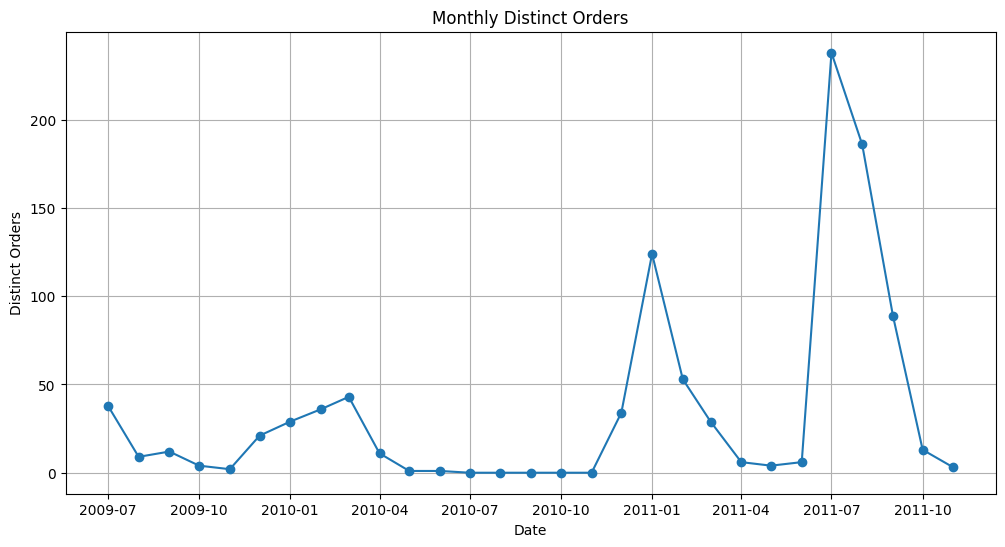

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(full_monthly_orders.to_timestamp(), marker='o', linestyle='-')
plt.title('Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Distinct Orders')
plt.grid()
plt.show()

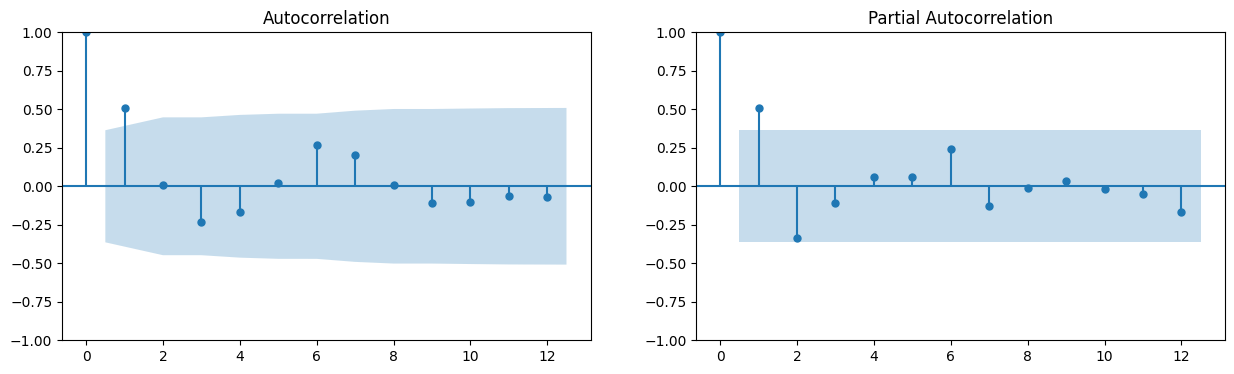

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(full_monthly_orders['Distinct Orders By Month'], lags=12, ax=axes[0])
plot_pacf(full_monthly_orders['Distinct Orders By Month'], lags=12, ax=axes[1])
plt.show()

In [ ]:
model = SARIMAX(full_monthly_orders['Distinct Orders By Month'],
                order=(1, 1, 0),
                seasonal_order=(1, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

In [ ]:
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)

forecast_index = pd.date_range(start=full_monthly_orders.index[-1].to_timestamp() + pd.offsets.MonthEnd(),
                               periods=forecast_steps, freq='M')
forecast_mean = np.maximum(forecast.predicted_mean, 0)
forecast_ci = forecast.conf_int()

forecast_ci.iloc[:, 0] = np.maximum(forecast_ci.iloc[:, 0], 0)
forecast_ci.iloc[:, 1] = np.maximum(forecast_ci.iloc[:, 1], 0)

<ipython-input-18-fe3af1d6e8af>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=full_monthly_orders.index[-1].to_timestamp() + pd.offsets.MonthEnd(),


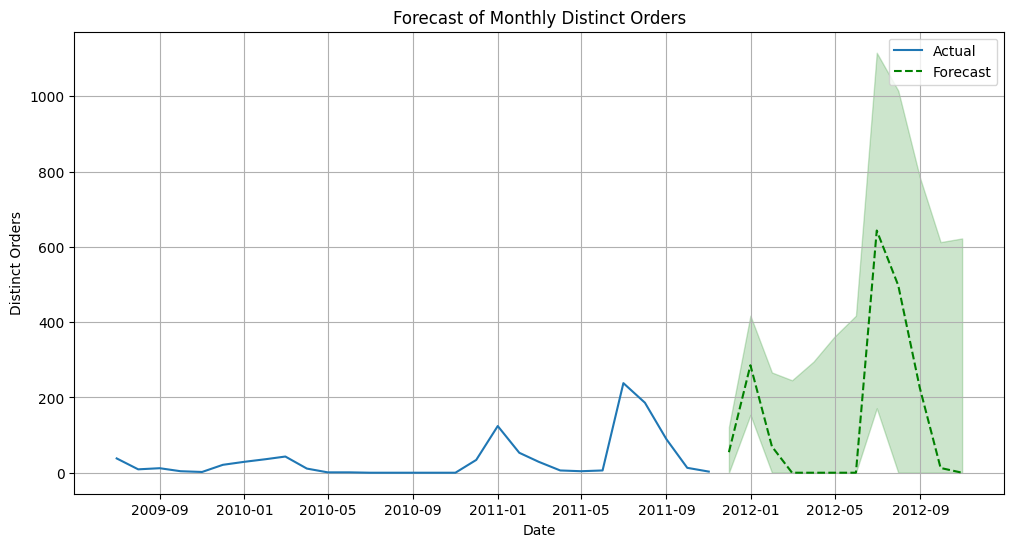

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(full_monthly_orders.index.to_timestamp(), full_monthly_orders['Distinct Orders By Month'], label='Actual')
plt.plot(forecast_index, forecast_mean, color='green', linestyle='--', label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('Forecast of Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Distinct Orders')
plt.legend()
plt.grid()
plt.show()

# New Section

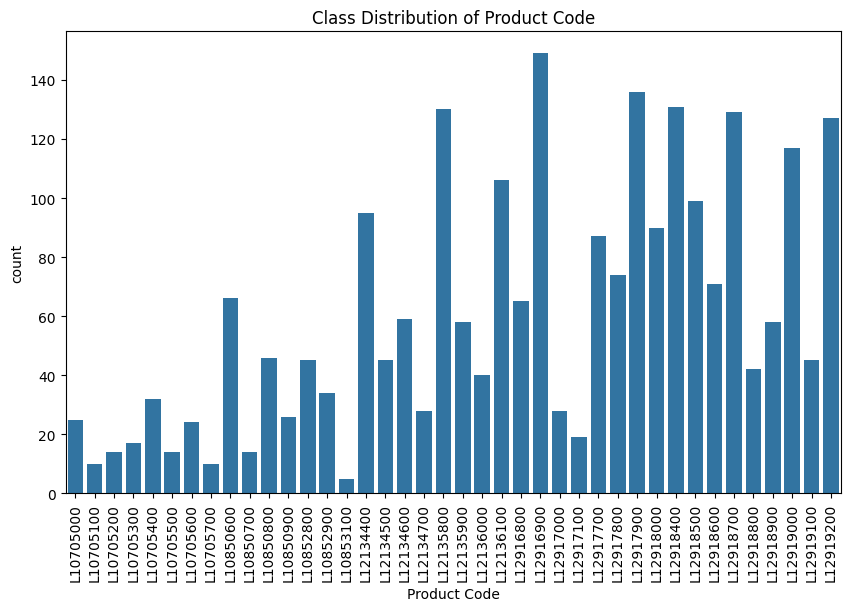

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='Product Code', data=df)
plt.title('Class Distribution of Product Code')
plt.xticks(rotation=90)
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

File not found locally, loading from GitHub URL.
Best parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Model Accuracy: 0.9896694214876033

Classification Report:
               precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         5
   L10705400       1.00      1.00      1.00         6
   L10705600       1.00      1.00      1.00         5
   L10850600       0.87      1.00      0.93        13
   L10850800       1.00      1.00      1.00         9
   L10850900       1.00      1.00      1.00         5
   L10852800       1.00      0.89      0.94         9
   L10852900       1.00      1.00      1.00         7
   L12134400       1.00      1.00      1.00        19
   L12134500       0.90      1.00      0.95         9
   L12134600       1.00      1.00      1.00        12
   L12134700       1.00      1.00      1.00         6
   L12135800       1.00      1.00   

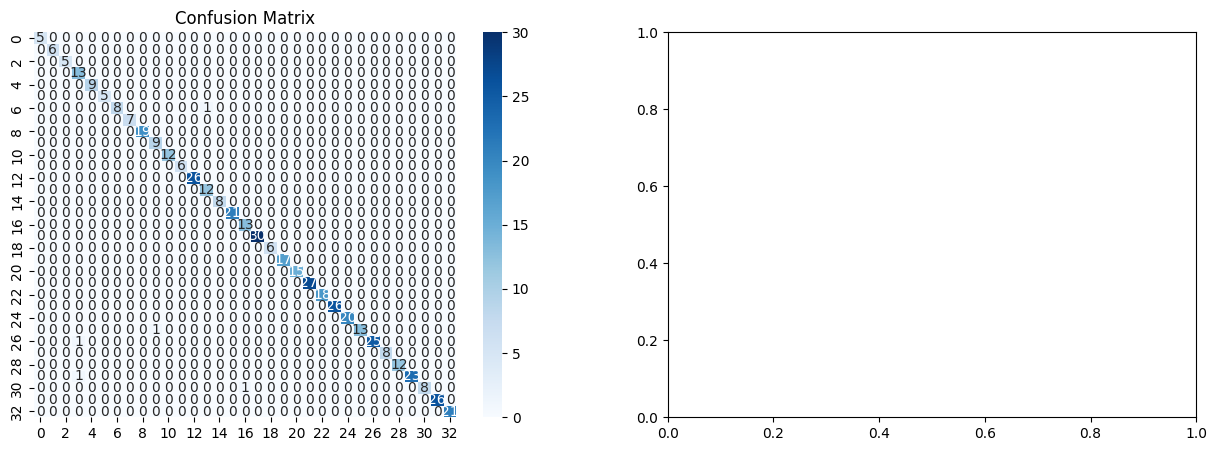

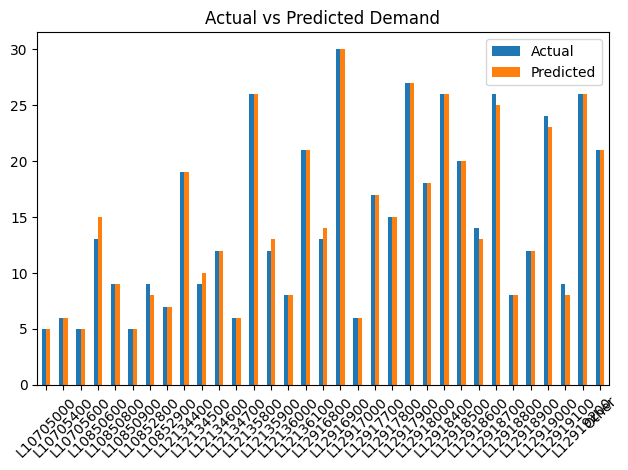

In [ ]:
class ProductDemandPredictor:
    def _init_(self):
        self.df = None
        self.model = None
        self.preprocessor = None

    def load_and_preprocess_data(self, file_path):
        # Load data
        try:
            self.df = pd.read_csv(file_path)
        except FileNotFoundError:
            # If file not found, try loading from URL (assuming raw GitHub link)
            url = "https://raw.githubusercontent.com/GitUser2277/MBAN_5110_Final_Exam/main/data_set_hackathon.csv"
            self.df = pd.read_csv(url)
            print("File not found locally, loading from GitHub URL.")


        # Convert dates
        date_columns = ['order_date', 'requested_delivery_date']
        for col in date_columns:
            self.df[col] = pd.to_datetime(self.df[col], format='%d.%m.%Y')

        # Handle missing values
        self.df.replace('\\N', np.nan, inplace=True)

        # Convert numeric columns
        self.df['items'] = pd.to_numeric(self.df['items'], errors='coerce')
        self.df['value'] = pd.to_numeric(self.df['value'], errors='coerce')

        return self

    def engineer_features(self):
        # Temporal features
        self.df['Month'] = self.df['order_date'].dt.month
        self.df['Year'] = self.df['order_date'].dt.year
        self.df['DayOfWeek'] = self.df['order_date'].dt.dayofweek
        self.df['Quarter'] = self.df['order_date'].dt.quarter

        # Season mapping
        self.df['Season'] = self.df['Month'].map({
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        })

        # Lead Time
        self.df['Lead_Time'] = (self.df['requested_delivery_date'] -
                               self.df['order_date']).dt.days

        # Value per item
        self.df['Value_per_Item'] = self.df['value'] / self.df['items']

        # Order frequency features
        order_stats = self.df.groupby('Product Code').agg({
            'order_date': ['count', 'nunique'],
            'value': 'mean',
            'items': 'mean'
        }).reset_index()

        order_stats.columns = ['Product Code', 'Order_Count',
                             'Unique_Orders', 'Avg_Value', 'Avg_Items']

        self.df = self.df.merge(order_stats, on='Product Code', how='left')

        return self

    def handle_outliers(self, columns, method='iqr'):
        for col in columns:
            if method == 'iqr':
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                self.df[col] = np.where(
                    (self.df[col] < lower_bound) | (self.df[col] > upper_bound),
                    self.df[col].median(),
                    self.df[col]
                )

        return self

    def prepare_features(self, threshold=20):
        # Group infrequent products
        product_counts = self.df['Product Code'].value_counts()
        frequent_products = product_counts[product_counts >= threshold].index
        self.df['Product Code'] = self.df['Product Code'].apply(
            lambda x: x if x in frequent_products else 'Other'
        )

        # Define features
        numeric_features = [
            'value', 'items', 'Lead_Time', 'Value_per_Item',
            'Order_Count', 'Unique_Orders', 'Avg_Value', 'Avg_Items'
        ]

        categorical_features = [
            'Customer Country Code', 'Route', 'Season',
            'Month', 'Quarter', 'DayOfWeek'
        ]

        # Create feature matrix
        X = self.df[numeric_features + categorical_features]
        y = self.df['Product Code']

        # Create preprocessor
        self.preprocessor = ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])

        return X, y

    def build_model(self, X, y):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Create pipeline with SMOTE
        model = ImbPipeline([
            ('preprocessor', self.preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced',
                n_jobs=-1
            ))
        ])

        # Define parameter grid
        param_grid = {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 15],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }

        # Perform grid search
        grid_search = GridSearchCV(
            model, param_grid, cv=3, scoring='accuracy', n_jobs=-1
        )

        # Fit model
        grid_search.fit(X_train, y_train)

        self.model = grid_search.best_estimator_

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Print results
        print("Best parameters:", grid_search.best_params_)
        print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        return y_test, y_pred

# Usage
predictor = ProductDemandPredictor()
predictor.load_and_preprocess_data('data_set_hackathon.csv')
predictor.engineer_features()
predictor.handle_outliers(['value', 'items', 'Lead_Time'])
X, y = predictor.prepare_features()
y_test, y_pred = predictor.build_model(X, y)

# Visualize results
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

# Demand Comparison
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
demand_comparison = pd.DataFrame({
    'Actual': results_df['Actual'].value_counts(),
    'Predicted': results_df['Predicted'].value_counts()
}).fillna(0)

plt.subplot(1, 2, 2)
demand_comparison.plot(kind='bar')
plt.title("Actual vs Predicted Demand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Empirical quantiles for each product:
               Q25  Q50    Q75
Product Code                 
L10705000     5.0  6.0   8.00
L10705100     6.5  9.0  12.25
L10705200     5.0  6.0  10.00
L10705300     5.0  7.0  10.00
L10705400     6.0  9.0  15.50

Sample Predictions with Quantile Regression:
   Actual  Predicted_Q25  Predicted_Median  Predicted_Q75
0    18.0      14.977588         18.076537      18.705706
1     6.0       5.977313          5.840715       6.608948
2     4.0       4.012553          3.951518       5.223385
3     3.0       2.879668          3.600394       3.708331
4     3.0       2.827899          3.000222       2.925639

Mean Absolute Percentage Error (MAPE) for Median Prediction: 13.47%


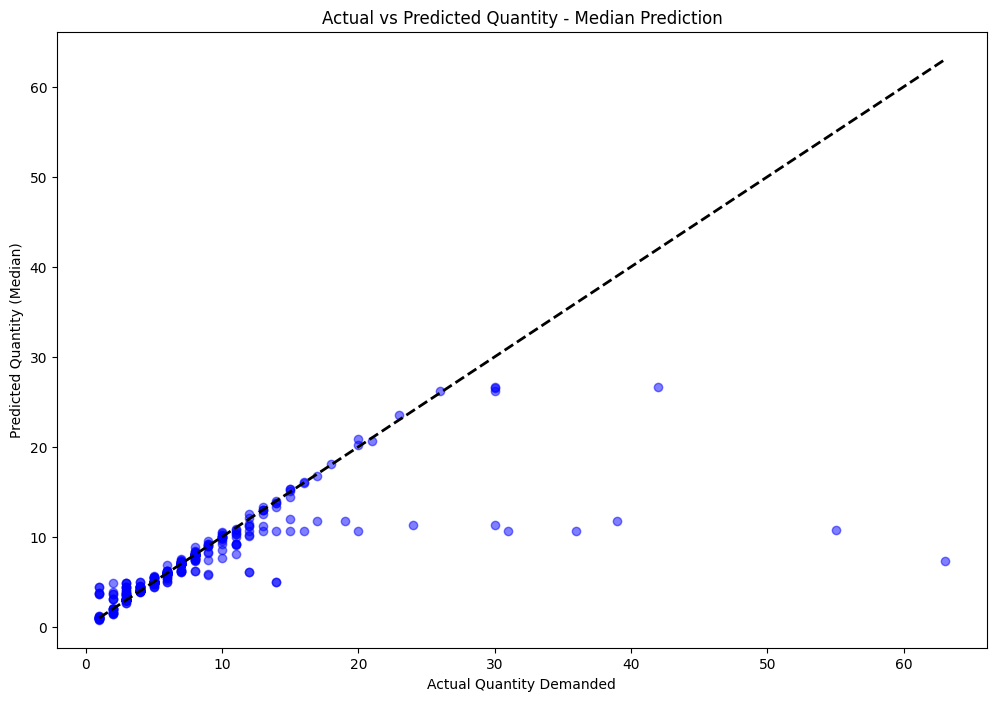

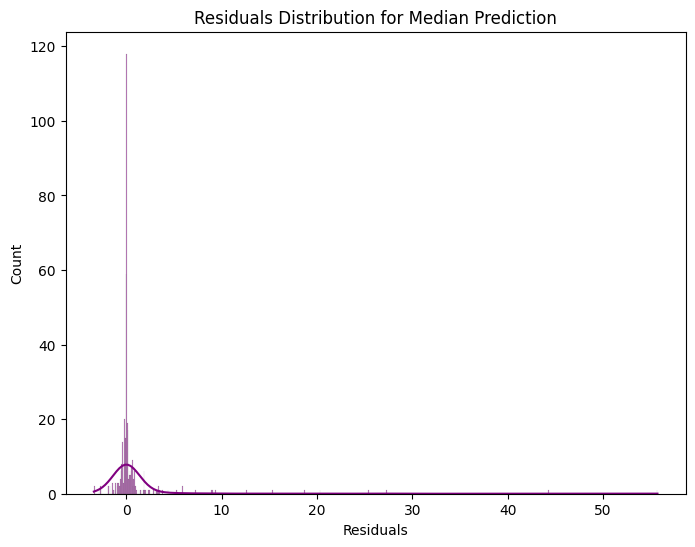


Final Results with Empirical Quantiles:
   Actual  Predicted_Q25  Predicted_Median  Predicted_Q75  Q25  Q50  Q75
0    18.0      14.977588         18.076537      18.705706  NaN  NaN  NaN
1     6.0       5.977313          5.840715       6.608948  NaN  NaN  NaN
2     4.0       4.012553          3.951518       5.223385  NaN  NaN  NaN
3     3.0       2.879668          3.600394       3.708331  NaN  NaN  NaN
4     3.0       2.827899          3.000222       2.925639  NaN  NaN  NaN


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ---------------------------
# Step 1: Load and preprocess the dataset
df = pd.read_csv(url)

# Convert date columns
if 'order_date' in df.columns:
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
if 'requested_delivery_date' in df.columns:
    df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Handle missing values
df['items'] = pd.to_numeric(df['items'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['Value_per_Item'] = df['value'] / df['items']  # Feature engineering: Value per item
df['Lead_Time'] = (df['requested_delivery_date'] - df['order_date']).dt.days
df.dropna(subset=['items', 'value', 'Lead_Time'], inplace=True)

# Aggregate product-level statistics
product_stats = df.groupby('Product Code').agg({
    'value': 'mean',
    'items': 'mean',
    'Lead_Time': 'mean'
}).reset_index()
product_stats.columns = ['Product Code', 'Avg_Value', 'Avg_Items', 'Avg_Lead_Time']
df = df.merge(product_stats, on='Product Code', how='left')

# ---------------------------
# Step 2: Compute Empirical Quantiles for Each Product
quantiles = [0.25, 0.5, 0.75]
quantile_df = df.groupby('Product Code')['items'].quantile(quantiles).unstack()
quantile_df.columns = [f'Q{int(q*100)}' for q in quantiles]
print("Empirical quantiles for each product:\n", quantile_df.head())

# ---------------------------
# Step 3: Prepare data for modeling
features = ['value', 'Lead_Time', 'Value_per_Item', 'Avg_Value', 'Avg_Items', 'Avg_Lead_Time']
X = df[features]
y = df['items']

# Split the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Step 4: Quantile Regression using Gradient Boosting
def fit_quantile_regression(X_train, y_train, alpha=0.5):
    """
    Fit a Gradient Boosting Regressor for quantile regression.
    :param X_train: Feature matrix for training
    :param y_train: Target variable for training
    :param alpha: Quantile to predict (0.5 for median)
    """
    model = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                      n_estimators=100, max_depth=3,
                                      random_state=42)
    model.fit(X_train, y_train)
    return model

# Train models for 25th, 50th (median), and 75th quantiles
models = {
    'Q25': fit_quantile_regression(X_train, y_train, alpha=0.25),
    'Q50': fit_quantile_regression(X_train, y_train, alpha=0.5),
    'Q75': fit_quantile_regression(X_train, y_train, alpha=0.75)
}

# Predict on the test set
predictions = {
    'Q25': models['Q25'].predict(X_test),
    'Q50': models['Q50'].predict(X_test),
    'Q75': models['Q75'].predict(X_test)
}

# ---------------------------
# Step 5: Evaluate and Display Results
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Q25': predictions['Q25'],
    'Predicted_Median': predictions['Q50'],
    'Predicted_Q75': predictions['Q75']
}).reset_index(drop=True)

print("\nSample Predictions with Quantile Regression:")
print(results.head())

# Evaluate MAPE for median predictions
mape = mean_absolute_percentage_error(y_test, predictions['Q50'])
print(f"\nMean Absolute Percentage Error (MAPE) for Median Prediction: {mape:.2f}%")

# ---------------------------
# Step 6: Visualization
plt.figure(figsize=(12, 8))

# Plot Actual vs Predicted for Median
plt.scatter(y_test, predictions['Q50'], alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Quantity Demanded")
plt.ylabel("Predicted Quantity (Median)")
plt.title("Actual vs Predicted Quantity - Median Prediction")
plt.show()

# Histogram of Residuals for Median
residuals = y_test - predictions['Q50']
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residuals Distribution for Median Prediction")
plt.xlabel("Residuals")
plt.show()

# ---------------------------
# Step 7: Combine Predictions with Empirical Quantiles
final_results = pd.concat([results, quantile_df.loc[df['Product Code'].unique()]], axis=1)
print("\nFinal Results with Empirical Quantiles:")
print(final_results.head())


In [ ]:
# Create a copy of the original dataset for cleaning
cleaned_df = df.copy()

# Convert 'items' to numeric, coercing invalid entries to NaN
cleaned_df['items'] = pd.to_numeric(cleaned_df['items'], errors='coerce')

# Handle missing values in 'items' (drop rows with NaN or replace with mean/median)
cleaned_df = cleaned_df.dropna(subset=['items'])  # Option 1: Drop rows with NaN in 'items'
# cleaned_df['items'].fillna(cleaned_df['items'].mean(), inplace=True)  # Option 2: Replace NaN with mean

# Recheck the data type and summary
print(cleaned_df['items'].dtype)
print(cleaned_df['items'].describe())


float64
count    2064.000000
mean        8.267926
std        19.667582
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
max       410.000000
Name: items, dtype: float64


Advance Demand: Mean = 8.887023886378309, Std = 22.280007335289334
Urgent Demand: Mean = 6.405825242718446, Std = 7.27345027074465
       Simulated Advance Demand  Simulated Urgent Demand  \
count               1000.000000              1000.000000   
mean                   8.919288                 6.589901   
std                   22.402977                 7.335597   
min                  -65.189977               -18.398884   
25%                   -6.180804                 1.287585   
50%                    9.616541                 6.494923   
75%                   23.180884                11.597078   
max                   69.315142                36.849052   

       Simulated Total Demand  
count             1000.000000  
mean                15.509189  
std                 23.626341  
min                -67.773836  
25%                 -0.610835  
50%                 15.680149  
75%                 30.531745  
max                 81.856520  
Advance Demand MAPE: 4.16
Urgent Demand 

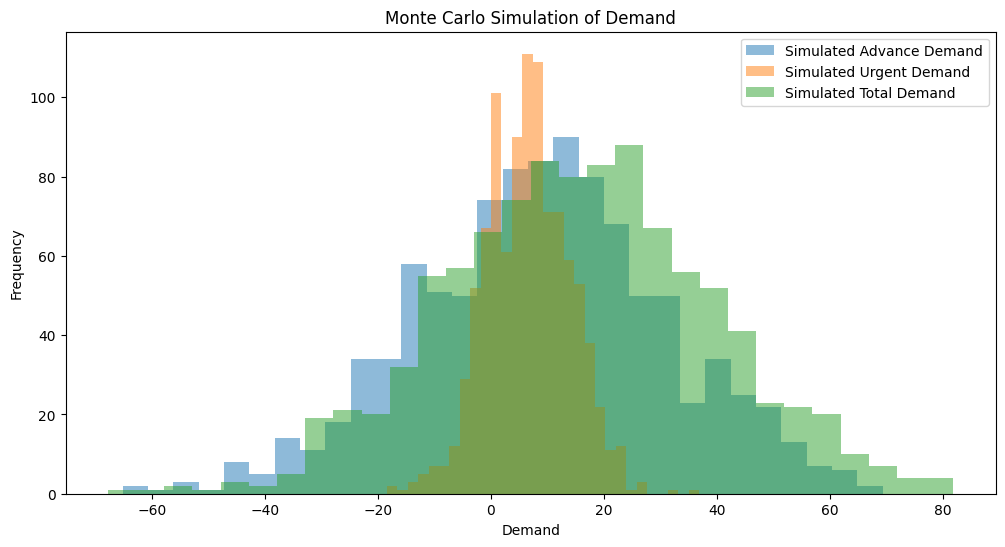

Monte Carlo Simulation completed successfully.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

# Step 1: Calculate Lead Time
cleaned_df['order_date'] = pd.to_datetime(cleaned_df['order_date'], format='%Y-%m-%d')
cleaned_df['requested_delivery_date'] = pd.to_datetime(cleaned_df['requested_delivery_date'], format='%Y-%m-%d')
cleaned_df['lead_time_days'] = (cleaned_df['requested_delivery_date'] - cleaned_df['order_date']).dt.days

# Step 2: Define Thresholds for Advance and Urgent Demand
urgent_threshold = cleaned_df['lead_time_days'].quantile(0.25)  # 25th percentile (e.g., 196 days)

# Split into advance and urgent demand
advance_demand = cleaned_df[cleaned_df['lead_time_days'] >= urgent_threshold]['items']
urgent_demand = cleaned_df[cleaned_df['lead_time_days'] < urgent_threshold]['items']

# Check for empty data and handle gracefully
if advance_demand.empty:
    raise ValueError("No data available for advance demand after filtering.")
if urgent_demand.empty:
    print("No data available for urgent demand. Using a fallback proportion.")
    urgent_demand = advance_demand.sample(frac=0.2, replace=True)  # Fallback mechanism

# Step 3: Characterize Distributions
advance_mean = advance_demand.mean()
advance_std = advance_demand.std()

urgent_mean = urgent_demand.mean()
urgent_std = urgent_demand.std()

print(f"Advance Demand: Mean = {advance_mean}, Std = {advance_std}")
print(f"Urgent Demand: Mean = {urgent_mean}, Std = {urgent_std}")

# Step 4: Monte Carlo Simulation
num_simulations = 1000
simulated_advance_demand = np.random.normal(advance_mean, advance_std, num_simulations)
simulated_urgent_demand = np.random.normal(urgent_mean, urgent_std, num_simulations)
simulated_total_demand = simulated_advance_demand + simulated_urgent_demand

# Analyze Simulated Data
simulation_results = pd.DataFrame({
    'Simulated Advance Demand': simulated_advance_demand,
    'Simulated Urgent Demand': simulated_urgent_demand,
    'Simulated Total Demand': simulated_total_demand
})

print(simulation_results.describe())

# Step 5: Compare with Actual Data
actual_advance_demand = advance_demand.sample(n=num_simulations, replace=True)
actual_urgent_demand = urgent_demand.sample(n=num_simulations, replace=True)

# Compute MAPE
advance_mape = mape(actual_advance_demand, simulated_advance_demand[:len(actual_advance_demand)])
urgent_mape = mape(actual_urgent_demand, simulated_urgent_demand[:len(actual_urgent_demand)])

print(f"Advance Demand MAPE: {advance_mape:.2f}")
print(f"Urgent Demand MAPE: {urgent_mape:.2f}")

# Step 6: Visualization
plt.figure(figsize=(12, 6))
plt.hist(simulated_advance_demand, bins=30, alpha=0.5, label='Simulated Advance Demand')
plt.hist(simulated_urgent_demand, bins=30, alpha=0.5, label='Simulated Urgent Demand')
plt.hist(simulated_total_demand, bins=30, alpha=0.5, label='Simulated Total Demand')
plt.legend()
plt.title('Monte Carlo Simulation of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

# Final Output
print("Monte Carlo Simulation completed successfully.")
